<a href="https://colab.research.google.com/github/jihyeon602/DeepLearning_practice/blob/main/GradCAM_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- CAM + CNN: 피쳐맵마다 중요도가 들어감 -> 좀더 진화된 모델
- 글로벌 에버리징 필요없이 가중치가 기울기 기반임

In [ ]:
!wget https://github.com/kairess/toy-datasets/raw/master/dog-inflammation.zip
!unzip -q dog-inflammation.zip

--2024-07-02 11:26:58--  https://github.com/kairess/toy-datasets/raw/master/dog-inflammation.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kairess/toy-datasets/master/dog-inflammation.zip [following]
--2024-07-02 11:26:59--  https://raw.githubusercontent.com/kairess/toy-datasets/master/dog-inflammation.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4592449 (4.4M) [application/zip]
Saving to: ‘dog-inflammation.zip’

dog-inflammation.zi 100%[===================>]   4.38M  --.-KB/s    in 0.06s   

2024-07-02 11:26:59 (76.7 MB/s) - ‘dog-inflammation.zip’ saved [4592449/4592449]



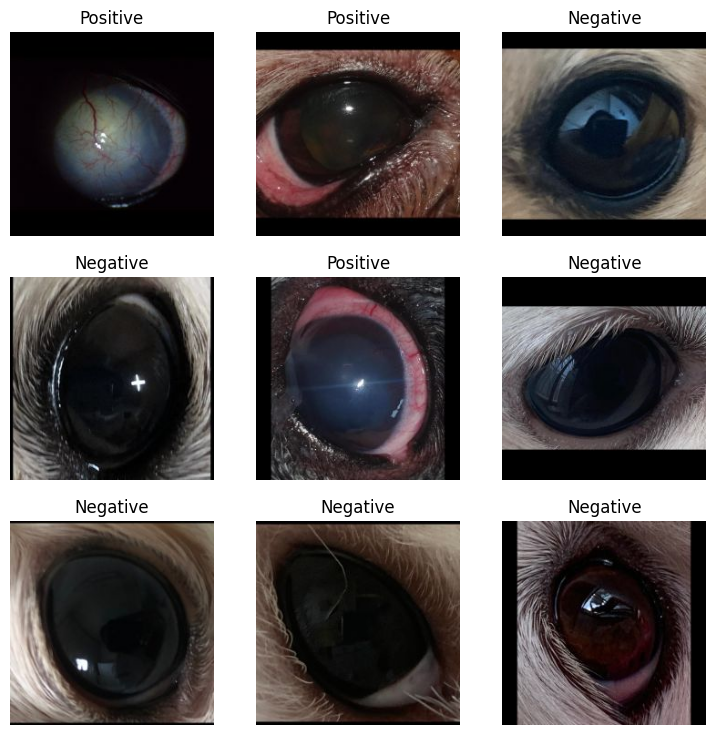

In [ ]:
#dataloader
from fastai.vision.all import *

path = 'dog-inflammation'

block = DataBlock(
    blocks = (ImageBlock, CategoryBlock), # Input, Output
    get_items = get_image_files, # PIL
    get_y = parent_label, # 폴더
)

loader = block.dataloaders(path)

loader.show_batch()

In [ ]:
# train # 전이 학습 - 파인 튜닝
learn = vision_learner(loader, resnet18, metrics=accuracy)
learn.fine_tune(epochs = 3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.582668,0.169380,0.950000,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.083824,0.087389,0.958333,00:02
1,0.052182,0.038116,0.983333,00:01
2,0.035379,0.023175,0.991667,00:01


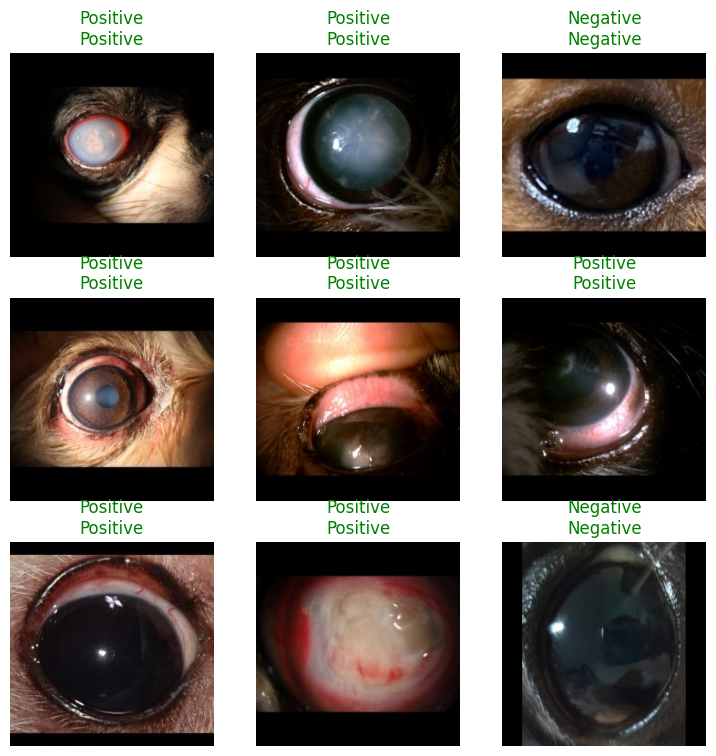

In [ ]:
# test result
learn.show_results() # 위에가 정답

torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])


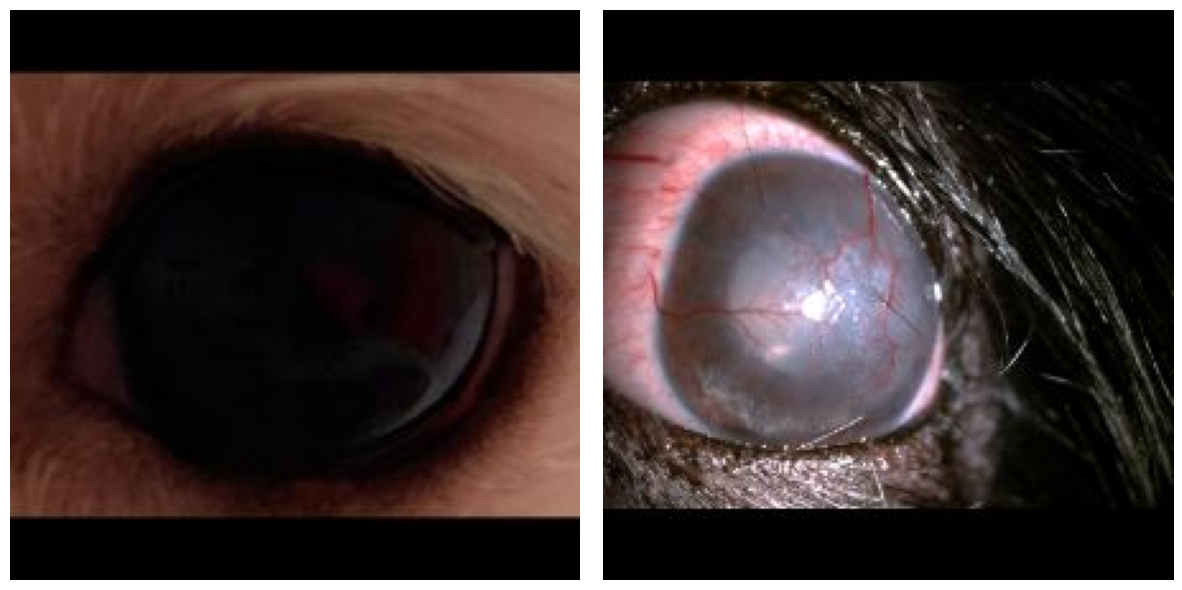

In [ ]:
# GradCAM
neg_path = '/content/dog-inflammation/Negative/D0_03f7e7c0-60a5-11ec-8402-0a7404972c70.jpg'
pos_path = '/content/dog-inflammation/Positive/D0_02fa7d26-60a5-11ec-8402-0a7404972c70.jpg'

test_loader = loader.test_dl([neg_path, pos_path]) # 전처리

neg_x, pos_x = next(iter(test_loader))[0]

neg_x = neg_x.unsqueeze(0)
pos_x = pos_x.unsqueeze(0)

print(neg_x.shape, pos_x.shape)

neg_img = Image.open(neg_path)
pos_img = Image.open(pos_path)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(neg_img)
ax[0].axis('off')
ax[1].imshow(pos_img)
ax[1].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)
    def hook_func(self, m, i, o): # 모듈, 입력, 출력
        self.stored = o.detach().clone()
    def __enter__(self, *args):
        return self
    def __exit__(self, *args):
        self.hook.remove()

class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)
    def hook_func(self, m, gi, go):
        self.stored = go[0].detach().clone()
    def __enter__(self, *args):
        return self
    def __exit__(self, *args):
        self.hook.remove()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


torch.Size([14, 14])


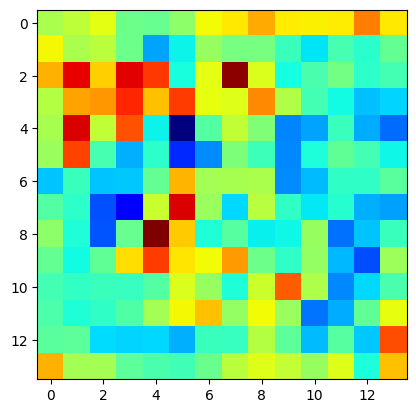

In [ ]:
def get_gradcam(x, location=-1): # 어느 레이어에서 뽑아낼껀지
    with HookBwd(learn.model[0][location]) as hookg:
        with Hook(learn.model[0][location]) as hook:
            output = learn.model.eval()(x.cuda())
            idx = torch.argmax(output)
            act = hook.stored
        output[0, idx].backward()
        grad = hookg.stored

    w = grad[0].mean(dim=[1, 2], keepdim=True)
    heatmap = (w * act[0]).sum(0).detach().cpu()

    return heatmap

heatmap = get_gradcam(pos_x, location=-2)

print(heatmap.shape)
plt.imshow(heatmap, cmap='jet')
plt.show()

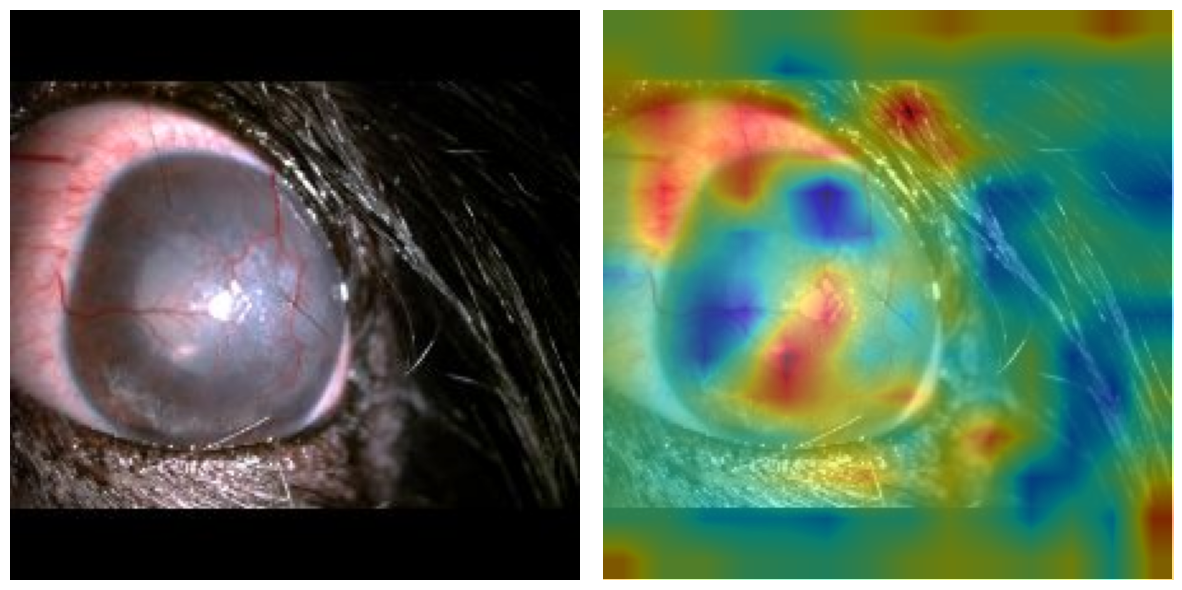

In [ ]:
# Positive
img = Image.open(pos_path)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img)
ax[0].axis('off')
ax[1].imshow(img)
ax[1].imshow(heatmap.cpu(), alpha=0.5, extent=(0,224,224,0),
              interpolation='bilinear', cmap='jet')
ax[1].axis('off')
plt.tight_layout()
plt.show()

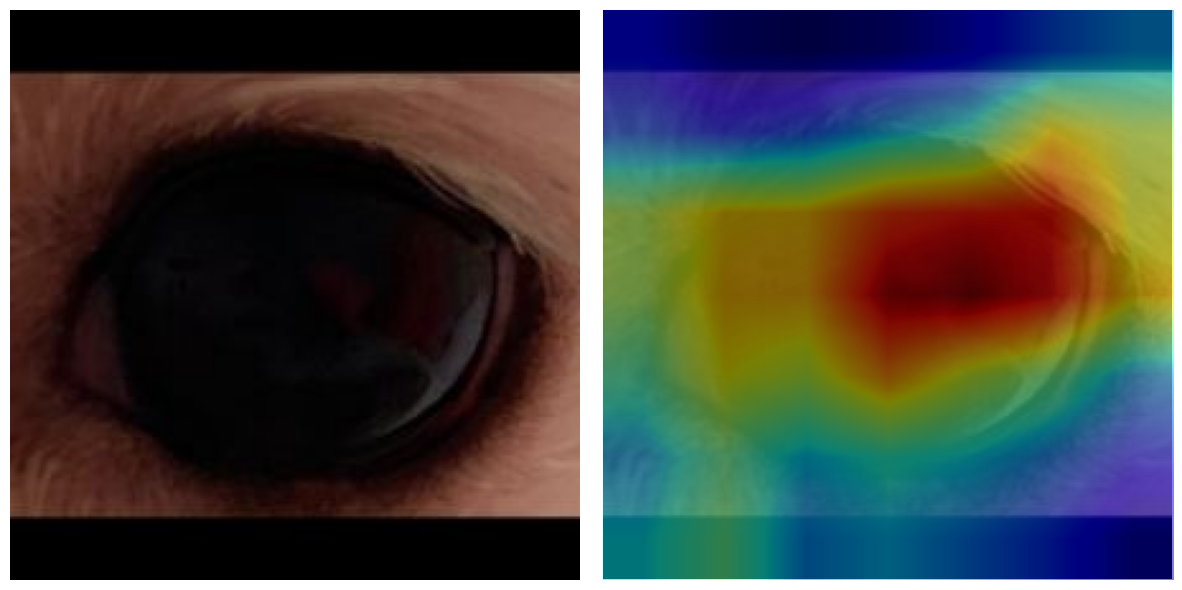

In [ ]:
# Negative
heatmap = get_gradcam(neg_x, location=-1)
img = Image.open(neg_path)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img)
ax[0].axis('off')
ax[1].imshow(img)
ax[1].imshow(heatmap.cpu(), alpha=0.5, extent=(0,224,224,0),
              interpolation='bilinear', cmap='jet')
ax[1].axis('off')
plt.tight_layout()
plt.show()